**IMPORTING DATA**

In [1]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 34.25 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ntpath
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Flatten
from keras.optimizers import Adam
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import os
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [3]:
datadir = 'track'
coloums = ['Center_img', 'Left_img', 'Right_img', 'Steering', 'Reverse', 'Throttle', 'Speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = coloums)
data.head()

Center_img  ...     Speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.615438

[5 rows x 7 columns]

In [4]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['Center_img'] = data['Center_img'].apply(path_leaf)
data['Right_img'] = data['Right_img'].apply(path_leaf)
data['Left_img'] = data['Left_img'].apply(path_leaf)
c = data['Center_img'][2]
data.head()

Center_img  ...     Speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

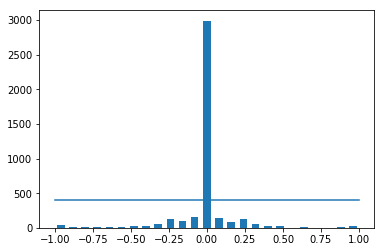

In [5]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['Steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samples_per_bin, samples_per_bin))

removed: 2590
remainind data:  1463


Center_img  ...     Speed
1   center_2018_07_16_17_11_43_670.jpg  ...  0.627942
8   center_2018_07_16_17_11_44_137.jpg  ...  0.598350
12  center_2018_07_16_17_11_44_413.jpg  ...  1.434013
13  center_2018_07_16_17_11_44_485.jpg  ...  2.173052
14  center_2018_07_16_17_11_44_558.jpg  ...  2.864847

[5 rows x 7 columns]

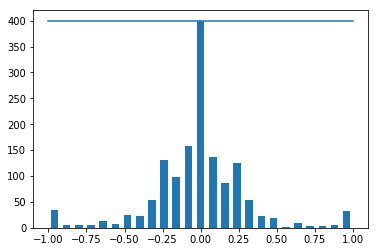

In [6]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['Steering'])):
    if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
      
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remainind data: ', len(data))
hist, _ = np.histogram(data['Steering'], num_bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samples_per_bin, samples_per_bin))
data.head()

**TRAIN TEST SPLIT**

In [7]:
print(data.iloc[2])

def load_center_steering_val(datadir):
  center_path = []
  steering_val = []
  for i in range(len(data)):
    
    indexed_data= data.iloc[i]
    center, left, right = indexed_data[0] , indexed_data[1] , indexed_data[2]
    center_path.append(os.path.join(datadir, center.strip()))
    steering_val.append(float(indexed_data[3]))
    
  center_paths= np.asarray(center_path)
  steering_vals = np.asarray(steering_val)
  return center_paths , steering_vals
  
center_paths, steering_vals = load_center_steering_val(datadir + '/IMG')


Center_img    center_2018_07_16_17_11_44_413.jpg
Left_img        left_2018_07_16_17_11_44_413.jpg
Right_img      right_2018_07_16_17_11_44_413.jpg
Steering                                   -0.05
Reverse                                 0.642727
Throttle                                       0
Speed                                    1.43401
Name: 12, dtype: object


In [0]:
X_train , X_val , Y_train , Y_val = train_test_split(center_paths , steering_vals , test_size = 0.2 , random_state = 1)

**DATA AUGMENTATION**

track/IMG/center_2018_07_16_17_16_04_344.jpg
0.3649963


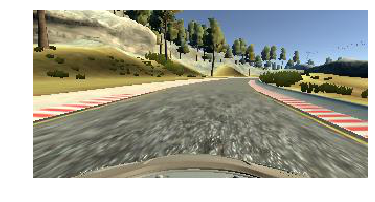

In [9]:
i = X_train[2]
print(i)
img = mpimg.imread(i)
plt.imshow(img)
plt.axis('off')
print(Y_train[2])

In [0]:
def zoom_in(image):
  zoom = iaa.Affine(scale = (1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed In Image')

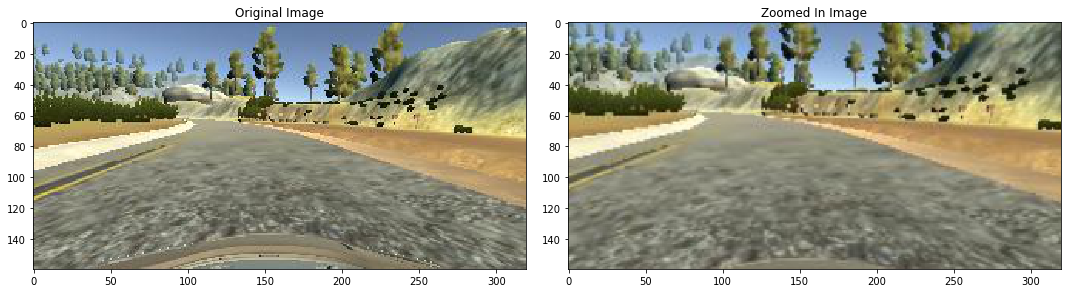

In [11]:
image = center_paths[50]
original = mpimg.imread(image)
zoomed = zoom_in(original)

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed)
axs[1].set_title('Zoomed In Image')

In [0]:
def zoom_out(image):
  zoom = iaa.Affine(scale = (0.7,1))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed  Out Image')

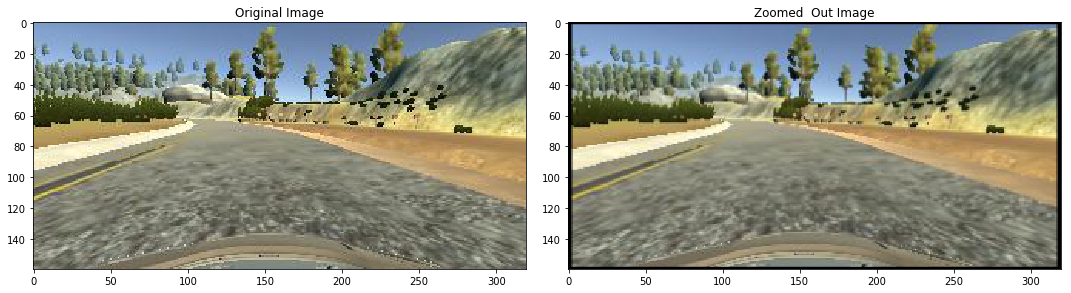

In [13]:
image = center_paths[50]
original = mpimg.imread(image)
zoomed = zoom_out(original)

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed)
axs[1].set_title('Zoomed  Out Image')

In [0]:
def random_brightness(image):
  bright = iaa.Multiply((0.2 , 1.4))
  image = bright.augment_image(image)
  return image

Text(0.5, 1.0, 'Bright Image')

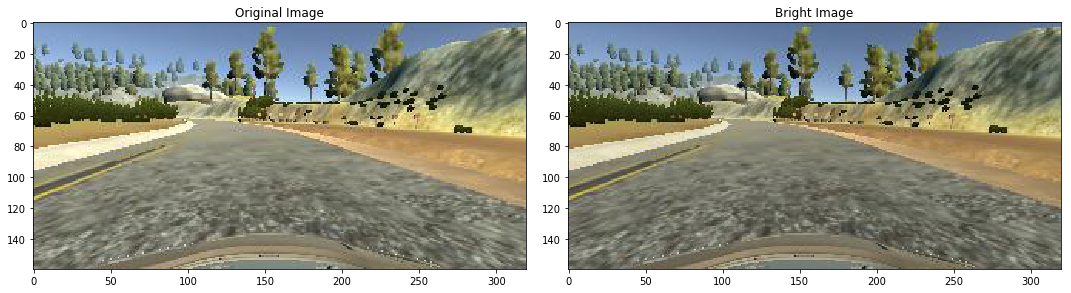

In [15]:
image = center_paths[50]
original = mpimg.imread(image)
bright = random_brightness(original)

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(bright)
axs[1].set_title('Bright Image')

In [0]:
def flip_image(image , steering_ang):
  image = cv2.flip(image, 1)
  steering_ang = steering_ang*(-1)
  return image , steering_ang

-0.05
0.05


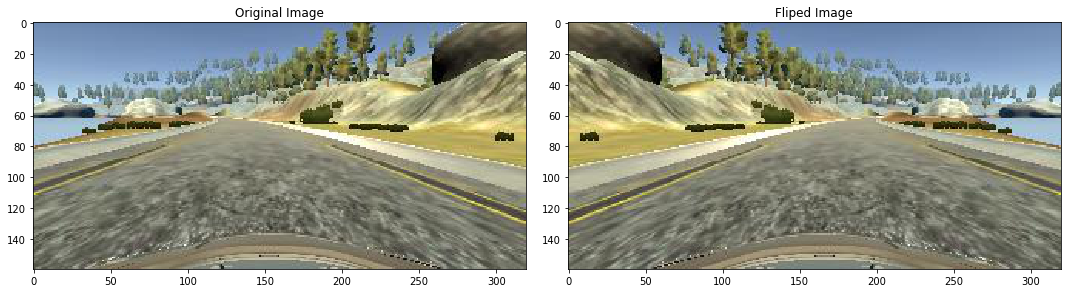

In [17]:
img = center_paths[100]
original = mpimg.imread(img)
steering1 = steering_vals[100]
fliped , steering2 = flip_image(original , steering1)

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
print(steering1)
axs[1].imshow(fliped)
axs[1].set_title('Fliped Image')
print(steering2)

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom_in(image)
   
  if np.random.rand() < 0.5:
    image = zoom_out(image)
    
  if np.random.rand() < 0.5:
    image = random_brightness(image)
    
  if np.random.rand() < 0.5:
    image, steering_angle = flip_image(image, steering_angle)
    
  return image, steering_angle

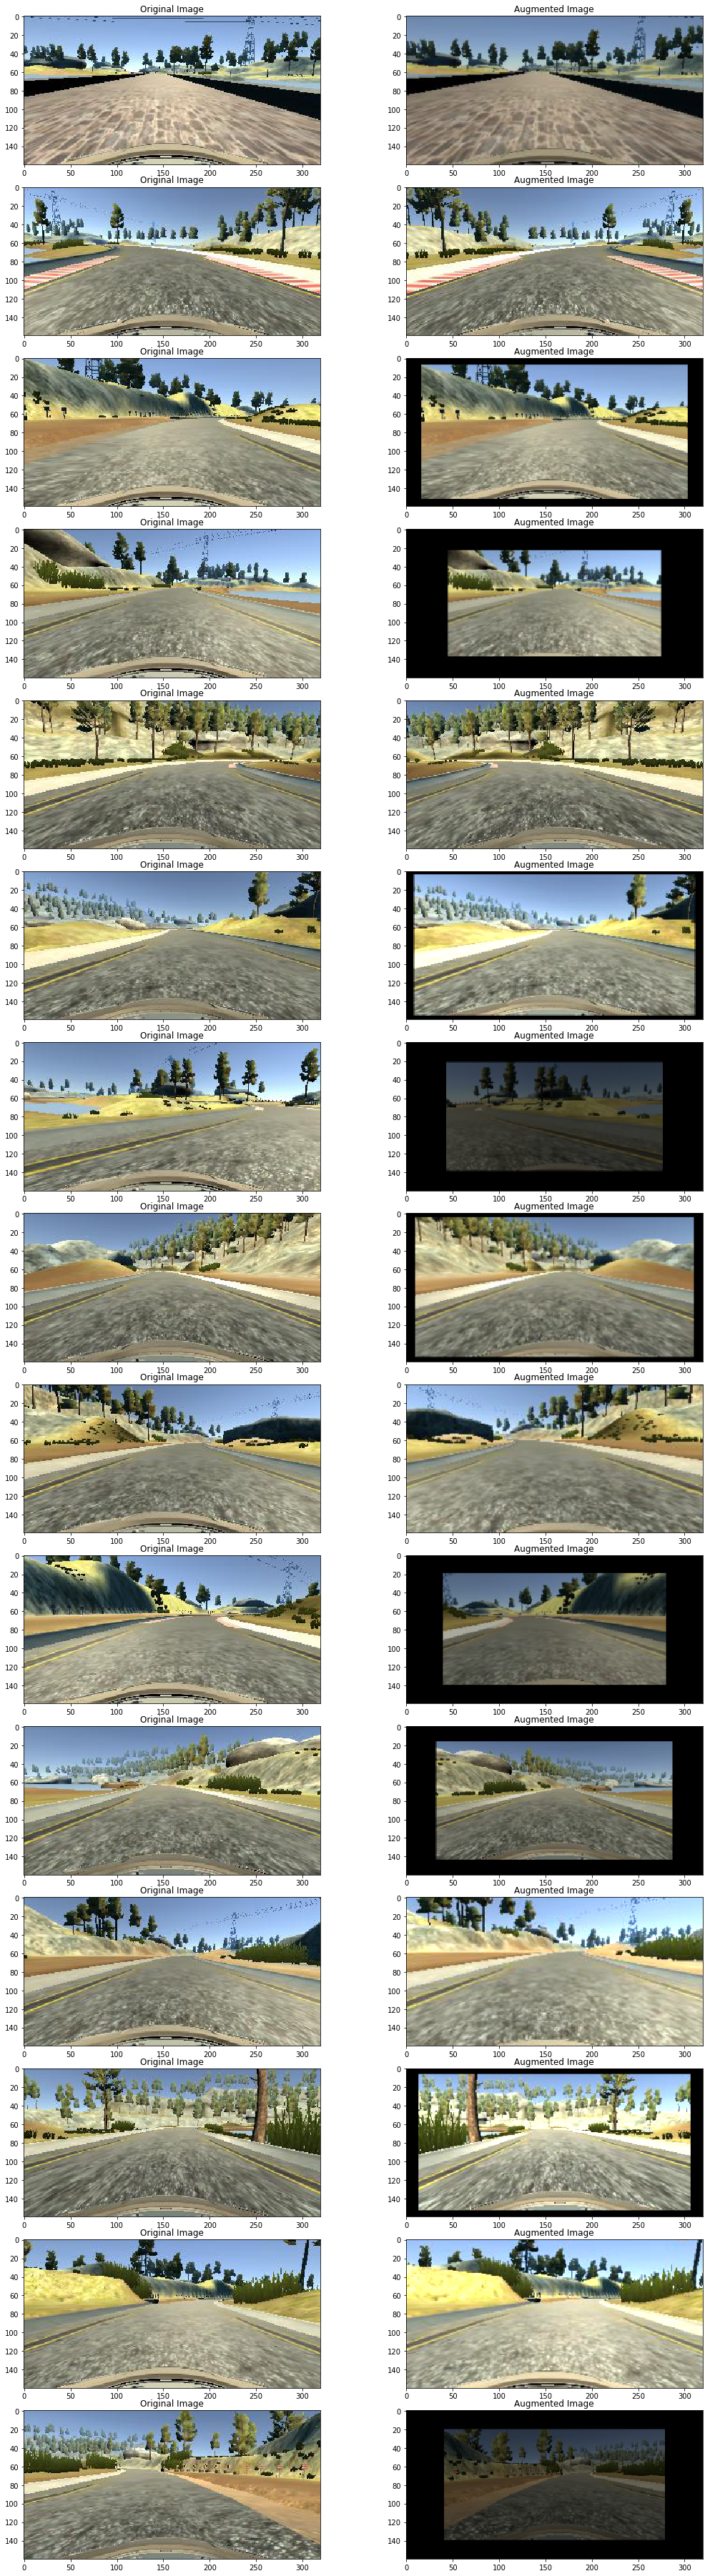

In [19]:
nrows = 15
ncols = 2
fig , axs = plt.subplots(nrows , ncols , figsize = (15 , 50))
fig.tight_layout()

for i in range(nrows):
  random_index = random.randint(0 , len(center_paths)-1)
  
  image_path = center_paths[random_index]
  original = mpimg.imread(image_path)
  r = steering_vals[random_index]
  augmented_img , steer = random_augment(image_path , steering_vals)
  
  axs[i][0].imshow(original)
  axs[i][0].set_title("Original Image")
  axs[i][1].imshow(augmented_img)
  axs[i][1].set_title("Augmented Image")

In [0]:
def preprocess(img):
  img = img[60:135 , : , : ,]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [0]:
def batch_generator(paths , steering , batch_size , check):
  
  while True:
    steer_val = []
    image = []
    for i in range(batch_size):
    
      random_ind = random.randint(0 , len(paths)-1)
      steer = steering[random_ind]
      steer_vals = 0
    
      if(check == 1):
        img , steer_vals = random_augment(paths[random_ind] , steer)
    
      else:
        img = mpimg.imread(paths[random_ind])
      
      imag = preprocess(img)
      image.append(imag)
      steer_val.append(steer_vals)

    yield (np.asarray(image) , np.asarray(steer_val))      

Text(0.5, 1.0, 'Validation Image , Steering angle = [0]')

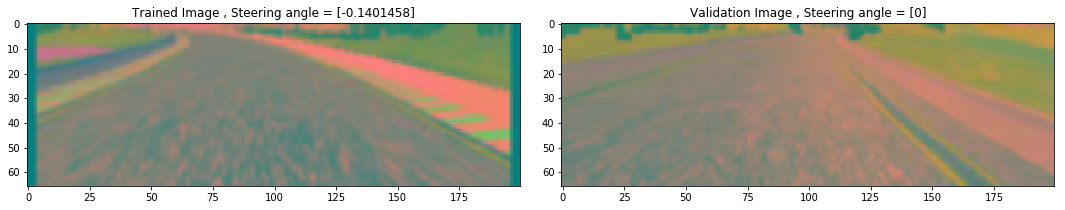

In [22]:
X_train_gen , Y_train_gen = next(batch_generator(X_train , Y_train , 1 , 1))
X_val_gen , Y_val_gen = next(batch_generator(X_val , Y_val , 1 , 0))

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0] )
axs[0].set_title('Trained Image , Steering angle = ' + str(Y_train_gen))
axs[1].imshow(X_val_gen[0] )
axs[1].set_title('Validation Image , Steering angle = ' + str(Y_val_gen))

**NVIDIA  MODEL**

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer = Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model
  

In [24]:
model = nvidia_model()
print(model.summary())

W0621 20:02:44.453557 139964448118656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
W0621 20:02:44.501793 139964448118656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 20:02:44.509030 139964448118656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [0]:
history = model.fit_generator(batch_generator(X_train, Y_train, 100, 1),
                              steps_per_epoch = 300, 
                              epochs = 10, 
                              validation_data = batch_generator(X_val, Y_val, 100, 0), 
                              validation_steps = 200, 
                              verbose = 1, 
                              shuffle = 1)

W0621 20:03:20.943099 139964448118656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0621 20:03:21.170902 139964448118656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
300/300 [==============================] - 143s 477ms/step - loss: 0.0988 - val_loss: 0.0547
Epoch 2/10
300/300 [==============================] - 134s 445ms/step - loss: 0.0430 - val_loss: 0.0490
Epoch 3/10
300/300 [==============================] - 132s 440ms/step - loss: 0.0336 - val_loss: 0.0730
Epoch 4/10
300/300 [==============================] - 130s 433ms/step - loss: 0.0282 - val_loss: 0.0597
Epoch 5/10
300/300 [==============================] - 130s 433ms/step - loss: 0.0247 - val_loss: 0.0767
Epoch 6/10
300/300 [==============================] - 130s 434ms/step - loss: 0.0216 - val_loss: 0.0678
Epoch 7/10
300/300 [==============================] - 130s 434ms/step - loss: 0.0195 - val_loss: 0.0537
Epoch 8/10
300/300 [==============================] - 131s 437ms/step - loss: 0.0187 - val_loss: 0.0729
Epoch 9/10
 75/300 [======>.......................] - ETA: 1:03 - loss: 0.0171

Text(0.5, 0, 'epoch')

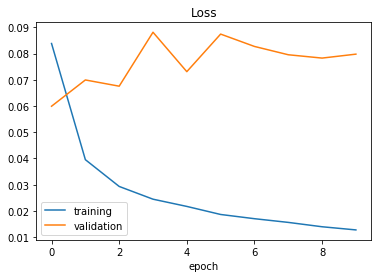

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')